In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
REBUILD_DATA = False

class RoadClassification():
    IMG_SIZE = 50
    Normal = "C:/Users/ASHIS/Downloads/Dataset/normal/"
    Pothole = "C:/Users/ASHIS/Downloads/Dataset/potholes/"
    LABELS = {Normal: 0, Pothole: 1}
    training_data = [] #massive list with a bunch of normal/potholes images with their lables
    n_count = 0
    p_count = 0

    def make_training_data(self):
        for label in self.LABELS: #iterating within the dir
            print(label)
            for f in tqdm(os.listdir(label)): #images within the dir
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]]) #2 Classes it indicates which index is "Switched On or 'Hot'"  
                
                        if label == self.Normal:
                            self.n_count += 1
                        elif label == self.Pothole:
                            self.p_count += 1

                    except Exception as e:
                        pass
                        
        np.random.shuffle(self.training_data) #shuffle inplace
        np.save("training_data.npy", self.training_data)
        print('Normal:',self.n_count)
        print('Pothole:',self.p_count)

if REBUILD_DATA:
    road_class = RoadClassification()
    road_class.make_training_data()

training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

13063


In [3]:
print(training_data[1])

#training_data[1][0] is an image
#training_data[1][1] is a one hot vector

[array([[136, 116, 127, ...,  68,  63,  78],
       [138, 155, 140, ...,  71,  96,  95],
       [122, 149,  98, ...,  81,  61,  66],
       ...,
       [103, 104,  81, ..., 145, 160, 154],
       [ 50,  33, 108, ..., 144, 143, 153],
       [ 93, 106,  97, ..., 163, 163, 154]], dtype=uint8)
 array([0., 1.])]


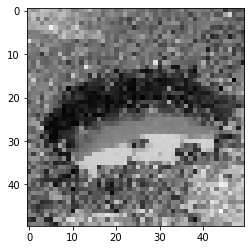

In [4]:
import matplotlib.pyplot as plt
plt.imshow(training_data[1][0],cmap="gray")
plt.show()

In [5]:
training_data[1][1]

array([0., 1.])

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() 
        # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) 
        # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) 
        # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) 
        #flattening.
        self.fc2 = nn.Linear(512, 2) 
        # 512 in, 2 out bcoz we're doing 2 classes.

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  
        # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        # bcoz this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


Loss_ReShaping_Validation

In [7]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
#scaling to (0-1) from (0-255)
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1  
# lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

1306


Train_Test_Split

In [8]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X), len(test_X))

11757 1306


In [9]:
BATCH_SIZE = 20
EPOCHS = 10

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): 
        
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step() # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

  0%|                                                                                                                                          | 0/588 [00:00<?, ?it/s]

Epoch: 0. Loss: 2.611304989841301e-05


  0%|                                                                                                                                          | 0/588 [00:00<?, ?it/s]

Epoch: 1. Loss: 4.399592853587819e-06


  0%|                                                                                                                                          | 0/588 [00:00<?, ?it/s]

Epoch: 2. Loss: 1.3886316310163238e-06


  0%|                                                                                                                                          | 0/588 [00:00<?, ?it/s]

Epoch: 3. Loss: 6.078568048906163e-07


  0%|                                                                                                                                          | 0/588 [00:00<?, ?it/s]

Epoch: 4. Loss: 3.1299259717343375e-07


  0%|                                                                                                                                          | 0/588 [00:00<?, ?it/s]

Epoch: 5. Loss: 1.7928198303707177e-07


  0%|                                                                                                                                          | 0/588 [00:00<?, ?it/s]

Epoch: 6. Loss: 1.0902823532887851e-07


  0%|                                                                                                                                          | 0/588 [00:00<?, ?it/s]

Epoch: 7. Loss: 6.847416500477266e-08


  0%|                                                                                                                                          | 0/588 [00:00<?, ?it/s]

Epoch: 8. Loss: 4.4386222697312405e-08


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 588/588 [02:48<00:00,  3.48it/s]

Epoch: 9. Loss: 2.9667138079503275e-08


In [10]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out =  net(test_X[i].view(-1, 1, 50, 50))[0]
        #returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
        
print("Accuracy: ", round(correct/total, 3))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1306/1306 [00:08<00:00, 157.94it/s]


Accuracy:  0.994
